# Pyrcca: regularized kernel canonical correlation analysis in Python and its applications to neuroimaging.

This notebook contains analyses and the figures for a Pyrcca analysis on a natural movie fMRI dataset described in the following e-print publication:

Bilenko, N.Y. and Gallant, J.L. (2015). Pyrcca: regularized kernel canonical correlation analysis in Python and its applications to neuroimaging. arXiv:1503.01538 [q-bio.QM] http://arxiv.org/abs/1503.01538

Download the Pyrcca code from this GitHub repository:
https://github.com/gallantlab/pyrcca

The dataset used in this notebook is publicly available on on CRCNS:
Nishimoto, S., Vu, A. T., Naselaris, T., Benjamini, Y., Yu, B., Gallant, J. L. (2014): Gallant Lab Natural Movie 4T fMRI Data. CRCNS.org.
http://dx.doi.org/10.6080/K00Z715X

Details of the experiments are described in the original publication about this data:
Nishimoto, S., Vu, A. T., Naselaris, T., Benjamini, Y., Yu, B., and Gallant, J. L. (2011). Reconstructing visual experiences from brain activity evoked by natural movies. Current Biology, 21(19), 1641-1646.

We use Pycortex software to visualize the results. This software is available here:
http://pycortex.org

To visualize the results in Pycortex, the anatomical files (available with the functional data on CRCNS) must be used to create a surface. We recommend Freesurfer:
http://freesurfer.net/

Freesurfer surface can be imported into pycortex and aligned with the functional data. This step also allows us to perform voxel selection by choosing only cortical voxels (those that fall within the cortex mask derived in Pycortex from the anatomical surface).

## Imports for neuroimaging data analysis

In [1]:
import h5py
import rcca
import sys
import numpy as np
import cortex
zscore = lambda d: (d-d.mean(0))/d.std(0)

## Load data from CRCNS

To run this code, download data from CRCNS: http://crcns.org/data-sets/vc/vim-2
The following analysis assumes that the data are located in a directory inside the current directory nameded "data".

In [2]:
data = []
vdata = []
numSubjects = 3
# subjects is a list of subject names in Pycortex corresponding to the three subjects in the analysis.
subjects = ['S1', 'S2', 'S3]
# xfms is a list of transform names in Pycortex aligning the functional and anatomical data for each subject.
xfms = ['S1_xfm', 'S2_xfm', 'S3_xfm']
dataPath ="./data/VoxelResponses_subject%d.mat"
for subj in range(numSubjects):
    # Open data file
    f = h5py.File(dataPath % (subj+1),'r')
    # Get size of the data
    datasize = (int(f["ei"]["datasize"].value[2]),int(f["ei"]["datasize"].value[1]),int(f["ei"]["datasize"].value[0]))
    # Get the cortical mask from Pycortex
    mask = cortex.db.get_mask(subjects[subj], xfms[subj], type = 'thick')
    # Get the training data for the subject
    data_subj = np.nan_to_num(zscore(np.nan_to_num(f["rt"].value.T)))
    data.append(data_subj.reshape((data_subj.shape[0],)+datasize)[:, mask])
    # Get the validation data for the subject
    vdata_subj = np.nan_to_num(zscore(np.nan_to_num(f["rv"].value.T)))
    vdata.append(vdata_subj.reshape((vdata_subj.shape[0],)+datasize)[:, mask])

## Define CCA parameters

In [3]:
# We will consider a range of regularization values betewen 1e-4 and 1e2
regs = np.array(np.logspace(-4, 2, 10))


# We will consider numbers of components between 3 and 10
numCCs = np.arange(3, 11)

# Initialize the cca object
cca = rcca.CCACrossValidate(numCCs=numCCs, regs=regs)

## Run and save the analysis

In [4]:
# NOTE: this analysis is computationally intensive due to the size of data. Running it in the notebook
# would take a considerable amount of time, so we recommend parallelizing it and/or running
# it on a computer cluster, and then loading in the results for visualization.

# Train the CCA mapping on training data
cca.train(data)

# Validate the CCA mapping on validation data
cca.validate(data)

# Compute variance explained for validation responses in each voxel
cca.compute_ev(vdata)

# Save analysis results
cca.save("./data/CCA_results.hdf5")

## Visualize results for one of the subjects

### Plot correlation histogram

Plot histograms of correlations between actual and predicted validation responses for all three subjects, as a result of cross-subject prediction.

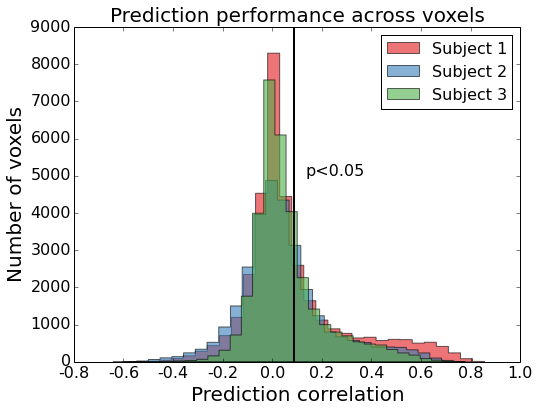

In [5]:
# Visualization imports
%matplotlib inline
import matplotlib.pyplot as plt

# Import Brewer colormaps for visualization
from brewer2mpl import qualitative

nSubj = len(cca.corrs)
nBins = 30
bmap = qualitative.Set1[nSubj]
f = plt.figure(figsize = (8, 6))
ax = f.add_subplot(111)
for s in range(nSubj):
    # Plot histogram of correlations across all voxels for all three subjects
    ax.hist(cca.corrs[s], bins = nBins, color = bmap.mpl_colors[s], histtype="stepfilled", alpha = 0.6)
plt.legend(['Subject 1', 'Subject 2', 'Subject 3'], fontsize = 16)
ax.set_xlabel('Prediction correlation', fontsize = 20)
ax.set_ylabel('Number of voxels', fontsize = 20)
ax.set_title("Prediction performance across voxels", fontsize = 20)
# Significance threshold at p<0.05 (corrected for multiple comparisons
# Significance is calculated using an asymptotic method (see paper text for detail)
thresh = 0.0893
ax.axvline(x = thresh, ymin = 0, ymax = 7000, linewidth = 2, color = 'k')
ax.text(thresh+0.05, 5000, 'p<0.05', fontsize = 16)
ax.set_xticklabels(0.1*np.arange(-8, 11, 2), fontsize = 16)
ax.set_yticklabels(np.arange(0, 10000, 1000), fontsize = 16)

### Cortical map plots

For more detail on visualization via Pycortex, please consult Pycortex documentation at http://pycortex.org

##### Correlation map

This map shows the correlations between predicted and actual validation responses as a result of cross-subject prediction for one of the subjects on the cortical map. Correlations that are not significant (p<0.05, corrected for multiple comparisons) are set to 0.

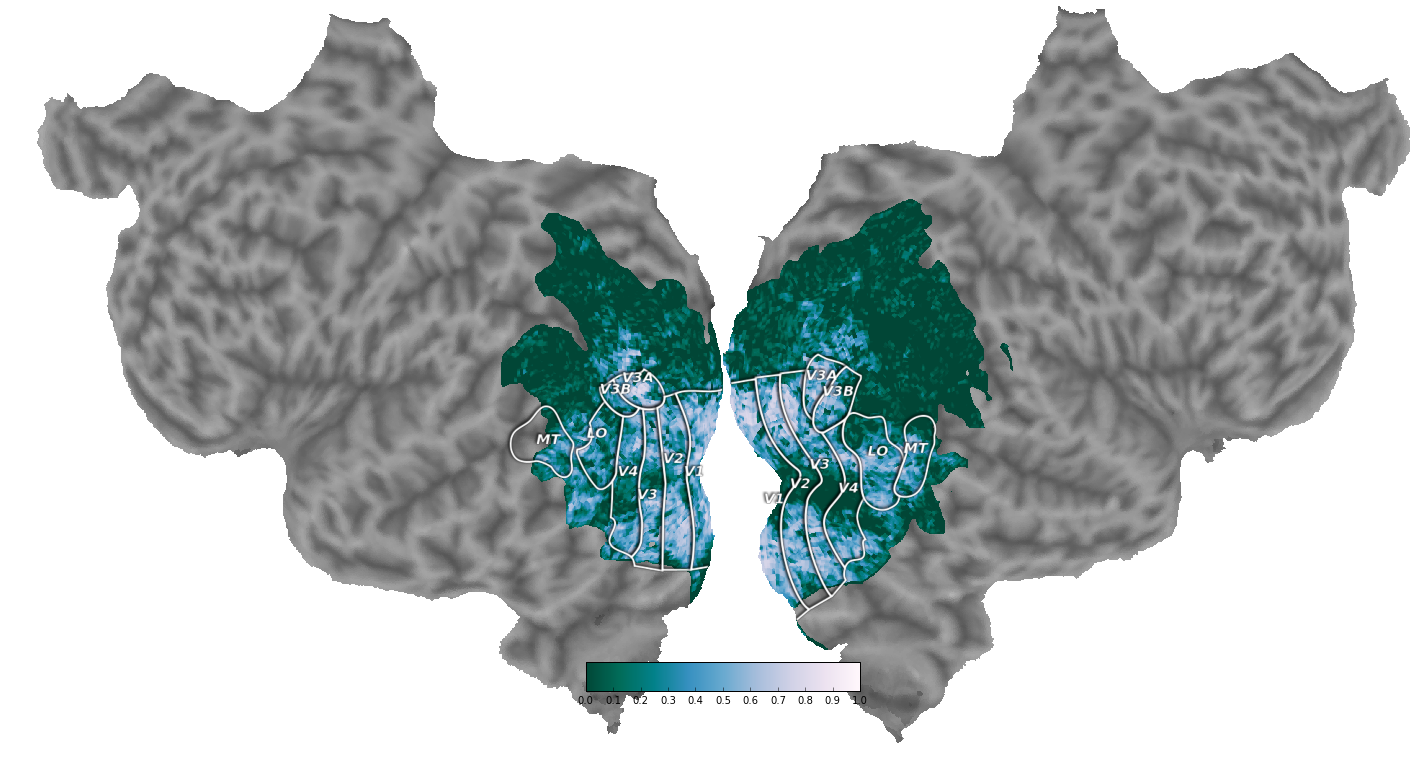

In [6]:
import cortex
from matplotlib import cm
from copy import deepcopy
subj = 0
subjName = "S1"
subjTransform = "S1_xfm"
corrs = deepcopy(cca.corrs[subj])
# Set all voxels below the signficance threshold to 0
corrs[corrs<thresh] = 0
_ = cortex.quickflat.make_figure(cortex.Volume(corrs, subjName, subjTransform, cmap = cm.PuBuGn_r, vmin = 0., vmax = 1.), with_curvature = True)

##### Canonical component RGB map

The canonical weights for all three canonical components estimated by Pyrcca are shown on a flattened cortical map. Each of the canonical components is assigned to one color channel. The first canonical component is represented by the red channel, the second canonical component is represented by green, and the third canonical component is represented by blue. Thus, the color of each voxel reflects its canonical weights for all three canonical components. Canonical weights have been rescaled to span the range from zero to one, and the absolute value of the weights has been taken. This map shows how the BOLD responses of each voxel are described by the three canonical components. The recovered map reveals retinotopic organization of the visual cortex.

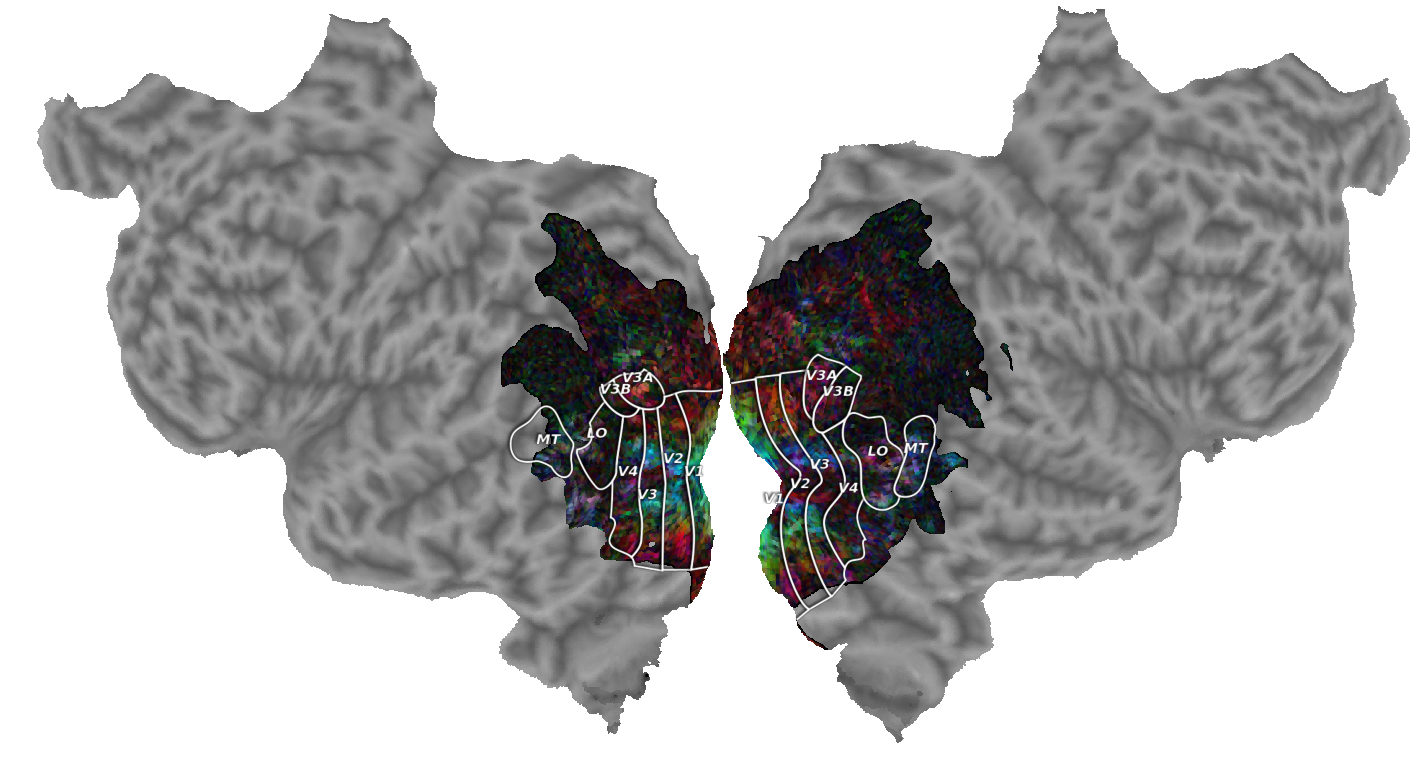

In [7]:
rescale = lambda d: 1/(d.max() - d.min())*(d - d.min())

_ = cortex.quickflat.make_figure(cortex.VolumeRGB(rescale(np.abs(cca.ws[0].T[0])), rescale(np.abs(cca.ws[0].T[1])), rescale(np.abs(cca.ws[0].T[2])), 'SNfs', 'SNfs4Tnb'), with_curvature = True, with_colorbar = False)

#### Individual canonical component maps

Each map shows both the canonical weights for one of the estimated canonical components and the variance of the held-out BOLD responses that was explained by that canonical component. Each voxel is colored according to a two-dimensional colormap. The hue represents the  canonical  weight  of  each  voxel.  Blue  indicates  negative  canonical  weights,  white  indicates  zero weights, and green indicates positive canonical weights. The canonical weights have been rescaled to span the range from -1 to 1. The saturation reflects the variance of each voxel’s held-out BOLD responses that is explained by that canonical component. The saturation ranges from 0% to 75%.

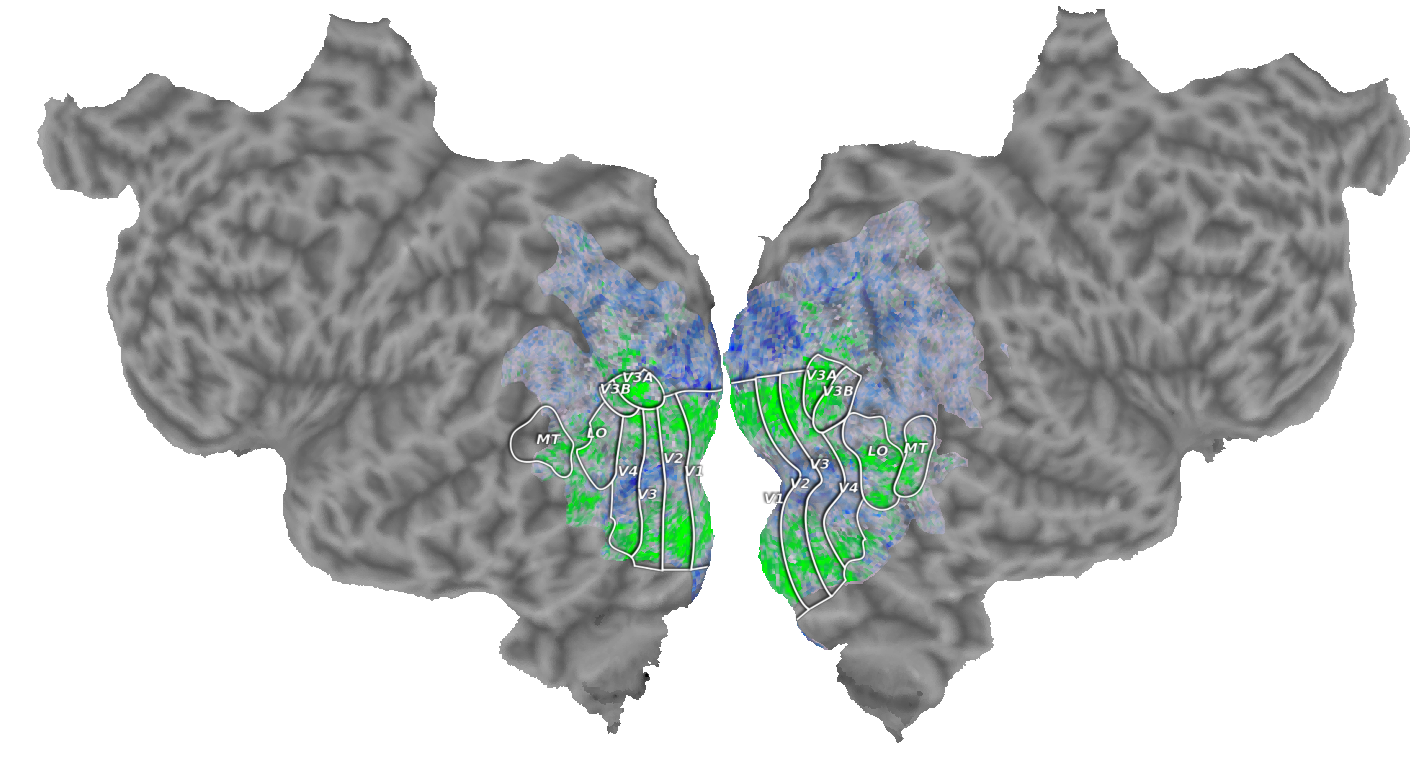

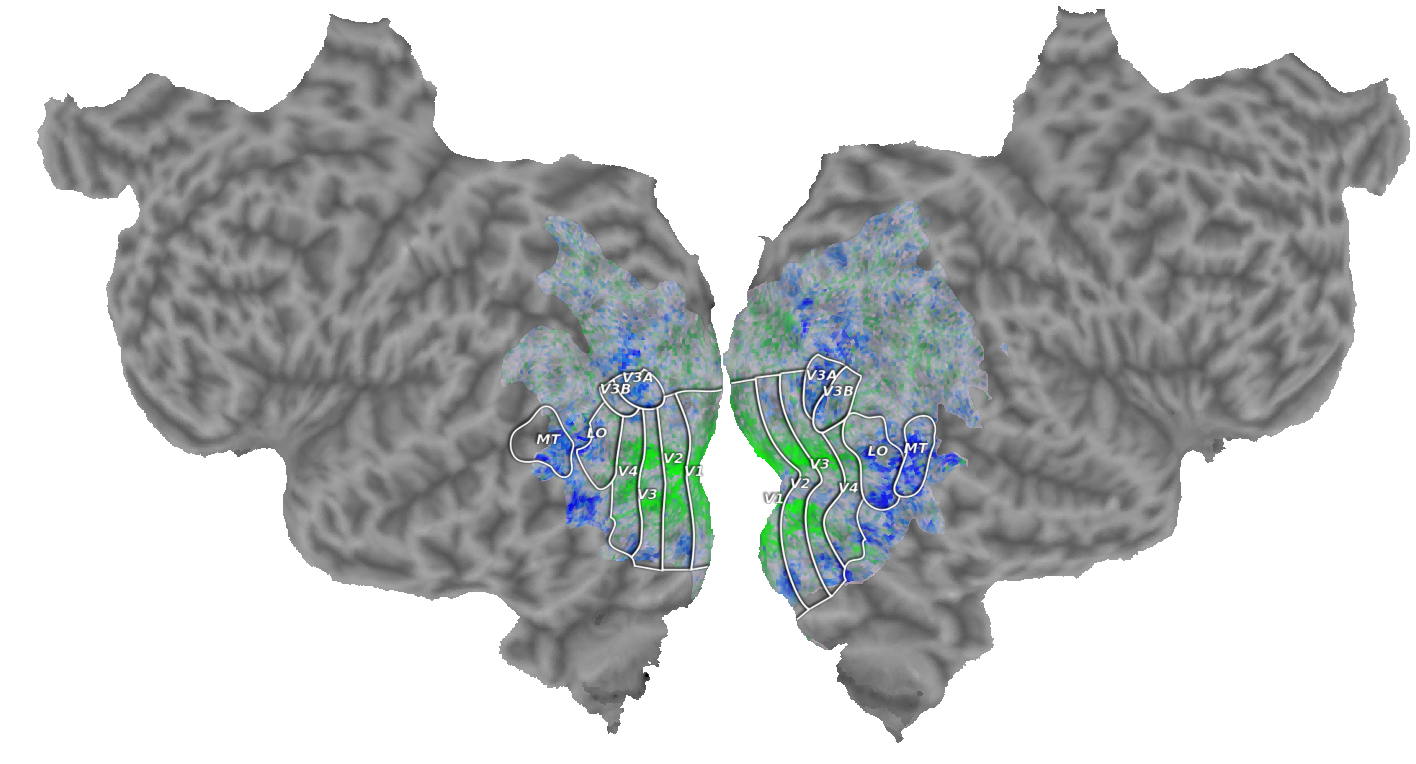

In [8]:
maxmins = [15, 50, 40]
for i in range(cca.best_numCC):
    cortex.quickflat.make_figure(cortex.Volume2D(np.nan_to_num(cca.ws[subj].T[i]), np.nan_to_num(cca.ev[subj][i]), subjName, subjTransform, cmap = "GreenWhiteBlue_2D", vmin = -maxmins[i], vmax = maxmins[i], vmin2 = 0, vmax2 = 0.75), with_curvature = True)